<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/Hunam_Activity_Recognition_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

np.random.seed(42)
tf.random.set_seed(42)
#

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip

--2024-08-02 04:34:56--  https://lazyprogrammer.me/course_files/timeseries/UCI-HAR.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI-HAR.zip’

UCI-HAR.zip         100%[===================>]  58.17M  73.2MB/s    in 0.8s    

2024-08-02 04:34:57 (73.2 MB/s) - ‘UCI-HAR.zip’ saved [60999314/60999314]



In [ ]:
!unzip -n UCI-HAR.zip

Archive:  UCI-HAR.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR Dataset

In [ ]:
# Check what is inside
!ls

 __MACOSX   sample_data  'UCI HAR Dataset'   UCI-HAR.zip


In [ ]:
!ls 'UCI HAR Dataset'

activity_labels.txt  features_info.txt	features.txt  README.txt  test	train


In [ ]:
!ls 'UCI HAR Dataset/train'

'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt


In [ ]:
!ls 'UCI HAR Dataset/train/Inertial Signals'

body_acc_x_train.txt  body_gyro_x_train.txt  total_acc_x_train.txt
body_acc_y_train.txt  body_gyro_y_train.txt  total_acc_y_train.txt
body_acc_z_train.txt  body_gyro_z_train.txt  total_acc_z_train.txt


In [ ]:
# Check length of X_train.txt file
!wc -l 'UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt'

7352 UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt


As there is 9 files, and we have 6 outputs, and there is 7352 input samples, so we will choose our hyperparameters accordingly.

In [ ]:
T = 128
N_train = 7352
N_test = 2947
D = 9 # Number of features for time series data
K = 6 # Number of outputs

In [ ]:
def load_data():
  """
  Returns:
    N_train(N, T, D): Number of training examples
    N_test(N, T, D): Number of testing examples
  """

  X_train = np.zeros((N_train, T, D))
  X_test = np.zeros((N_test, T, D))

  train_prefix = 'UCI HAR Dataset/train/Inertial Signals/'
  train_file_names = [
      'body_acc_x_train.txt',  'body_gyro_x_train.txt',  'total_acc_x_train.txt',
      'body_acc_y_train.txt',  'body_gyro_y_train.txt',  'total_acc_y_train.txt',
      'body_acc_z_train.txt',  'body_gyro_z_train.txt',  'total_acc_z_train.txt'
  ]

  for d, fn in enumerate(train_file_names):
    df = pd.read_csv(f'{train_prefix}{fn}', header=None, delim_whitespace=True)

    x = df.to_numpy()
    X_train[:, :, d] = x

  Y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None) - 1

  # Let's do the same for X_test
  test_prefix = 'UCI HAR Dataset/test/Inertial Signals/'
  test_files = [
        'body_acc_x_test.txt',  'body_gyro_x_test.txt',  'total_acc_x_test.txt',
        'body_acc_y_test.txt',  'body_gyro_y_test.txt',  'total_acc_y_test.txt',
        'body_acc_z_test.txt',  'body_gyro_z_test.txt',  'total_acc_z_test.txt'
  ]
  for d, fn in enumerate(test_files):
    df = pd.read_csv(f'{test_prefix}{fn}', header=None, delim_whitespace=True)
    x = df.to_numpy()
    X_test[:, :, d] = x

  Y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None) - 1

  return X_train, Y_train, X_test, Y_test


In [ ]:
X_train, Y_train, X_test, Y_test = load_data()

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


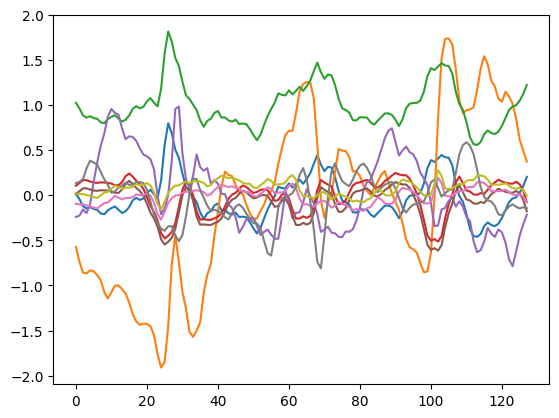

In [ ]:
# Let's plot the random data sample
plt.plot(X_train[5432,:,:]);

In [ ]:
# Let's have simple LSTM
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = LSTM(32, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 9)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128, 32)             │           5,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128, 32)             │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,894 (54.27 KB)

 Trainable params: 13,894 (54.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoints = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

In [ ]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
r = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoints]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.5370 - loss: 1.2590

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


230/230 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step - accuracy: 0.5378 - loss: 1.2573 - val_accuracy: 0.8724 - val_loss: 0.5064
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - accuracy: 0.9145 - loss: 0.3552 - val_accuracy: 0.9016 - val_loss: 0.3123
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 116ms/step - accuracy: 0.9394 - loss: 0.2014 - val_accuracy: 0.9077 - val_loss: 0.2710
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.9470 - loss: 0.1652 - val_accuracy: 0.9125 - val_loss: 0.2385
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.9474 - loss: 0.1518 - val_accuracy: 0.9118 - val_loss: 0.2257
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.9508 - loss: 0.1335 - val_accuracy: 0.9121 - val_loss: 0.2565
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.9429 - loss: 0.1316 - val_accuracy: 0.8758 - val_loss: 0.3052
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.9466 - loss: 0.1340 - val

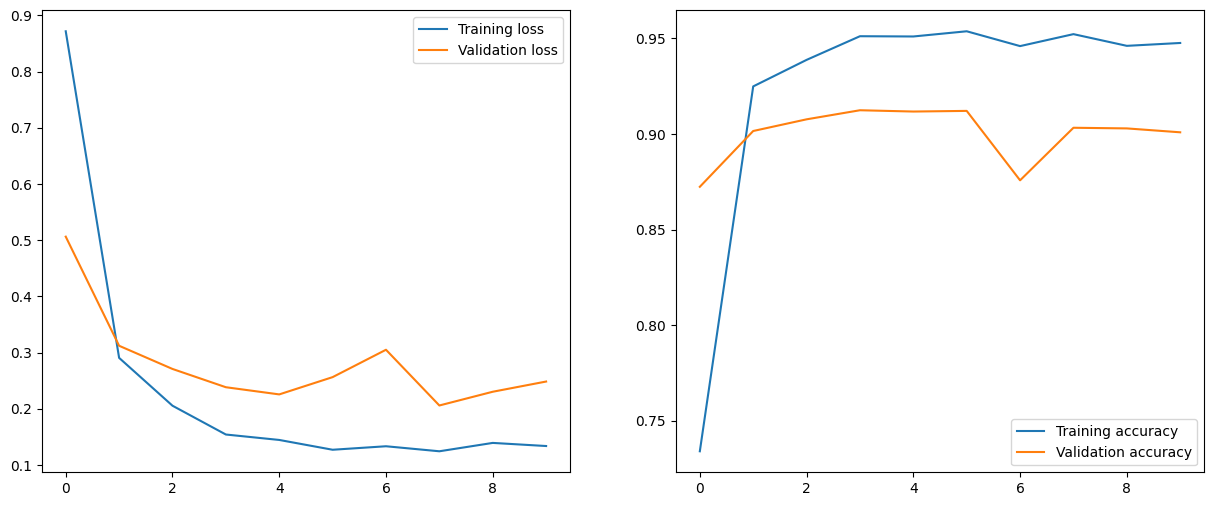

In [ ]:
# Plot loss and accuracy graph
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(r.history['loss'], label='Training loss')
ax[0].plot(r.history['val_loss'], label='Validation loss')
ax[0].legend()
ax[1].plot(r.history['accuracy'], label='Training accuracy')
ax[1].plot(r.history['val_accuracy'], label='Validation accuracy')
ax[1].legend();

In [ ]:
# Load best model
best_model = tf.keras.models.load_model('best_model.keras')

In [ ]:
# Predict
Y_pred = best_model.predict(X_test)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


In [ ]:
np.array(Y_test).flatten().shape

(2947,)

In [ ]:
# Check accuracy
np.mean(np.argmax(Y_pred, axis=1) == np.array(Y_test).flatten())

0.9032914828639295

As we can see we have achieved 90% accuracy.

### Now let's work with features as well

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
def load_features():
  df = pd.read_csv('UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True)
  feat_train = df.to_numpy()

  # Test features
  df = pd.read_csv('UCI HAR Dataset/test/X_test.txt', header=None, delim_whitespace=True)
  feat_test = df.to_numpy()

  return feat_train, feat_test


In [ ]:
feat_train, feat_test = load_features()

In [ ]:
D_feat = feat_train.shape[1]

In [ ]:
# Create combine RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)


i_feat = Input(shape=(D_feat,))
x_feat = Dense(32, activation='relu')(i_feat)

x = Concatenate()([x, x_feat])
x = Dense(K, activation='softmax')(x)

model = Model([i, i_feat], x)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 9)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 128, 32)        │          5,376 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 561)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 32)             │              0 │ lstm_4[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │         17,984 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64)             │              0 │ global_max_pooling1d_… │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 6)              │            390 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,750 (92.77 KB)

 Trainable params: 23,750 (92.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Let's compile
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# Check point
checkpoints = ModelCheckpoint('best_model_combine.keras', save_best_only=True, monitor='val_loss')

In [ ]:
# Let's train
r = model.fit(
    [X_train, feat_train], Y_train,
    validation_data=([X_test, feat_test], Y_test),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoints]
)

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8445 - loss: 0.5157

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.8446 - loss: 0.5151 - val_accuracy: 0.8483 - val_loss: 0.3321
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.9303 - loss: 0.2020 - val_accuracy: 0.9053 - val_loss: 0.2285
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9542 - loss: 0.1358 - val_accuracy: 0.9125 - val_loss: 0.2066
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9613 - loss: 0.1118 - val_accuracy: 0.9264 - val_loss: 0.1794
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.9710 - loss: 0.0868 - val_accuracy: 0.9209 - val_loss: 0.1836
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9731 - loss: 0.0800 - val_accuracy: 0.9359 - val_loss: 0.1644
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9717 - loss: 0.0764 - val_accuracy: 0.9376 - val_loss: 0.1567
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.9757 - loss: 0.0653 - val_accurac

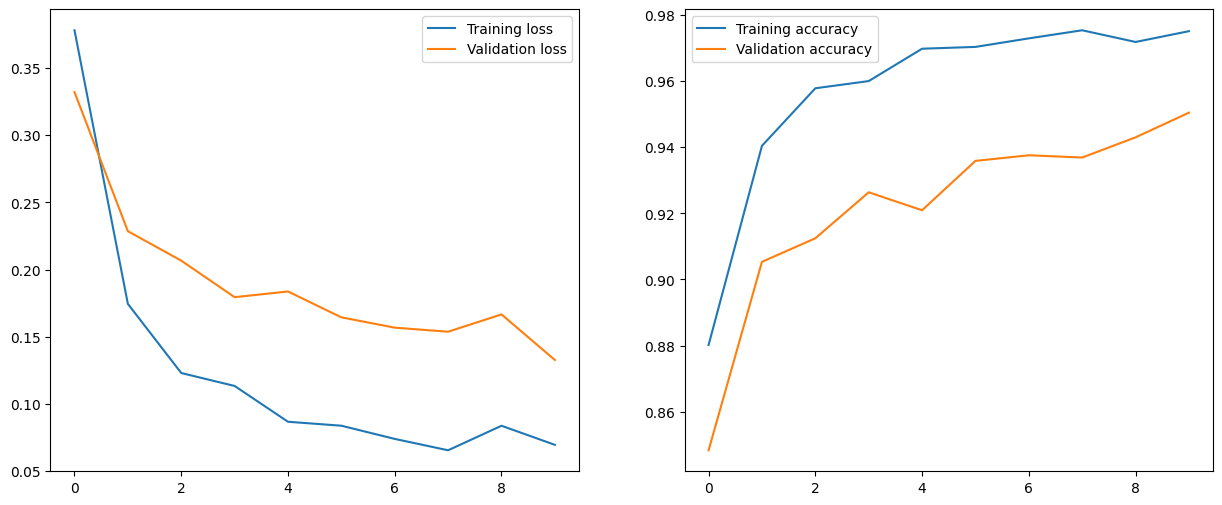

In [ ]:
# Let's plot
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(r.history['loss'], label='Training loss')
ax[0].plot(r.history['val_loss'], label='Validation loss')
ax[0].legend()
ax[1].plot(r.history['accuracy'], label='Training accuracy')
ax[1].plot(r.history['val_accuracy'], label='Validation accuracy')
ax[1].legend();


In [ ]:
# Load best model
best_model = tf.keras.models.load_model('best_model_combine.keras')

In [ ]:
# Predict
Y_pred = best_model.predict([X_test, feat_test])

93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


In [ ]:
# Find accuracy
np.mean(np.argmax(Y_pred, axis=1) == np.array(Y_test).flatten())

0.9504580929759077

As you can see, we have now achieved 95% of accuracy